# Fit program reading .tdms files with Fourier transform

Units of the x-axis is Volt

Last change: 13.11.2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile
from scipy.special import wofz

import mvfunctions as mv

from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'mvfunctions'

### Load data and preparation

In [2]:
filename = '0_Z31_201509-A1a'


tdms_file = TdmsFile(filename + ".tdms")
nsp=tdms_file.object().property("Sampling_Points")
nr=tdms_file.object().property("No_of_Repetitions")
#channel = tdms_file.object('PD_Signal_0', 'Avg_Data_0')

print("The following Groups and Channels are available:")
for group in tdms_file.groups():
    print(group)
    for channel in tdms_file.group_channels(group):
        print(channel)

s1 = pd.Series(tdms_file.object('Reference', 'Ramp_Output').data)

channels=[]

for i in range(nr):
    channelName='Avg_Data_'+str(i)
    s2=pd.Series(tdms_file.object('PD_Signal_0', channelName).data)
    df_data=pd.concat([s1, s2], axis=1)
    df_data.columns = ['x','y']
    channels.append(df_data)
    plt.plot(df_data['x'], df_data['y'])
plt.show()

yAverage=np.zeros(nsp)

#Set nrr=1 if only first channel to be considered;
#set nrr=i if average of the first i channels to be considered;
#set nrr=nr for average on all available channels
nrr=5
for i in range(nrr):
    yAverage=yAverage+channels[i]['y']
    
yAverage=np.divide(yAverage,nrr)

df_data=pd.concat([s1, pd.Series(yAverage)], axis=1)
df_data.columns = ['x','y']

NameError: name 'TdmsFile' is not defined

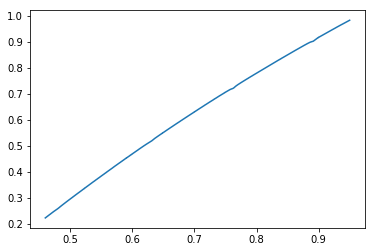

In [3]:
raw_red = df_data[(df_data.x > 0.46) & (df_data.x < 0.95)]
plt.plot(raw_red['x'], raw_red['y'])
plt.show()

## Definitions of functions

In [4]:
def B(x,a,b,c,d,e):
    return a+b*x+c*x**2+d*x**3+e*x**4

def Lor_sum(x,p11,p21,x01,p12,p22,x02,p13,p23,x03,p14,p24,x04):
    return p11*p21/np.pi/((x-x01)**2+p21**2) + p12*p22/np.pi/((x-x02)**2+p22**2) + p13*p23/np.pi/((x-x03)**2+p23**2)+p14*p24/np.pi/((x-x04)**2+p24**2)

def Itot(x,a,b,c,d,e,p11,p21,x01,p12,p22,x02,p13,p23,x03,p14,p24,x04):
    return B(x,a,b,c,d,e)*(1+Lor_sum(x,p11,p21,x01,p12,p22,x02,p13,p23,x03,p14,p24,x04))

def V(x,A,x0,alpha,gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha / np.sqrt(2 * np.log(2))

    return A*np.real(wofz((x-x0 + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

def Voigt_sum(x,A1,x01,alpha1,gamma1,A2,x02,alpha2,gamma2,A3,x03,alpha3,gamma3,A4,x04,alpha4,gamma4):
    return V(x,A1,x01,alpha1,gamma1) + V(x,A2,x02,alpha2,gamma2) + V(x,A3,x03,alpha3,gamma3) + V(x,A4,x04,alpha4,gamma4)

def Itot_Voigt(x,a,b,c,d,e,A1,x01,alpha1,gamma1,A2,x02,alpha2,gamma2,A3,x03,alpha3,gamma3,A4,x04,alpha4,gamma4):
    return B(x,a,b,c,d,e)*(1+Voigt_sum(x,A1,x01,alpha1,gamma1,A2,x02,alpha2,gamma2,A3,x03,alpha3,gamma3,A4,x04,alpha4,gamma4))

### Fit to find initial parameters for $B(x)$

In [5]:
poptb, pcovb = curve_fit(B, raw_red['x'], raw_red['y'])

### Fit to find initial parameters for $I(x)$

In [6]:
# Find background with Voigt + polynomial
# initial_parameters = [poptb[0],poptb[1],poptb[2],poptb[3],poptb[4],0.1,1.73,0.01,0.01,
#                      0.1,1.94,0.01,0.01,
#                      0.1,2.13,0.01,0.01,
#                      0.1,2.33,0.01,0.01]
#popt, pcov = curve_fit(Itot_Voigt, raw_red['x'], raw_red['y'], initial_parameters)

In [7]:
initial_parameters = [poptb[0],poptb[1],poptb[2],poptb[3],poptb[4], 0.01,0.01,0.48,0.01,0.01,0.63,0.01,0.01,0.76,0.01,0.01,0.89]
popt, pcov = curve_fit(Itot, raw_red['x'], raw_red['y'], initial_parameters)

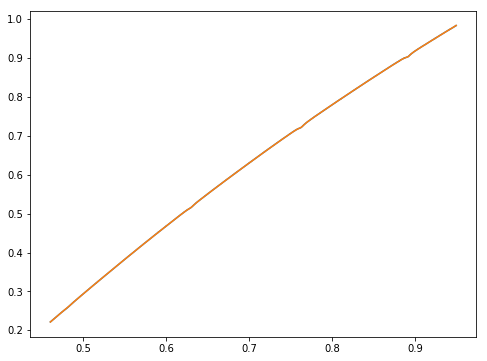

In [8]:
plt.figure(figsize=(8,6))
plt.plot(raw_red['x'], raw_red['y'])
plt.plot(raw_red['x'], Itot(raw_red['x'], *tuple(popt)))
plt.show()

### Calculation of absorbance

In [9]:
Absorb = -np.log (raw_red['y'] / B(raw_red['x'], popt[0], popt[1], popt[2], popt[3], popt[4]))

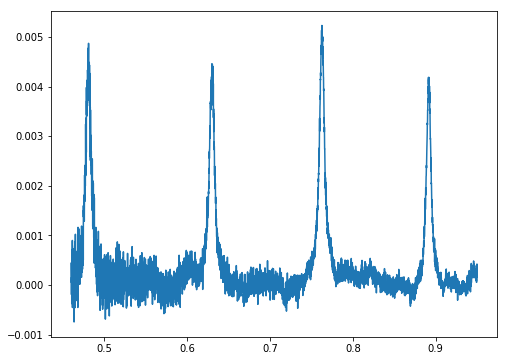

In [10]:
plt.figure(figsize=(8,6))
plt.plot(raw_red['x'], Absorb)
plt.show()

### Fit of the absorbance with Lorenzian

In [11]:
popti, pcovi = curve_fit(Lor_sum, raw_red['x'], Absorb, initial_parameters[5:17])
resid = Absorb - Lor_sum(raw_red['x'], *tuple(popti))

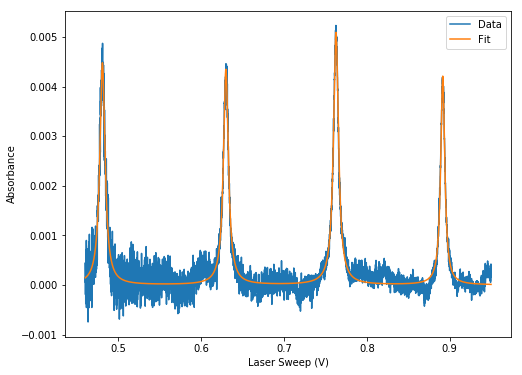

In [12]:
plt.figure(figsize=(8,6))
plt.xlabel("Laser Sweep (V)")
plt.ylabel("Absorbance")
plt.plot(raw_red['x'], Absorb, label = "Data")
plt.plot(raw_red['x'], Lor_sum(raw_red['x'], *tuple(popti)), label = "Fit")
plt.legend(loc = "upper right")
plt.show()

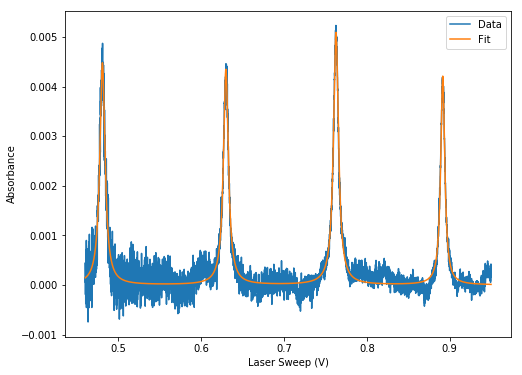

In [13]:
plt.figure(figsize=(8,6))
plt.xlabel("Laser Sweep (V)")
plt.ylabel("Absorbance")
plt.plot(raw_red['x'], Absorb, label = "Data")
plt.plot(raw_red['x'], Lor_sum(raw_red['x'], *tuple(popti)), label = "Fit")
plt.legend(loc = "upper right")
#plt.xlim(2.13,2.14)
plt.show()

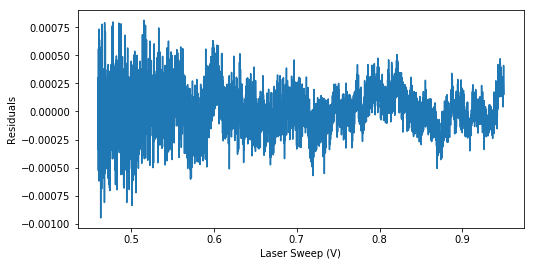

In [14]:
plt.figure(figsize=(8,4))
#plt.xlim(1.6,2.45)
plt.xlabel("Laser Sweep (V)")
plt.ylabel("Residuals")
plt.plot(raw_red['x'], resid)
plt.show()

### Fit of the absorbance with Voigt

In [15]:
initial_par_Voigt=[0.01,popt[7],0.01,0.01,0.01,popt[10],0.01,0.01,.01,popt[13],0.1,0.01,.01,popt[16],0.1,0.1]

poptiV, pcoviV = curve_fit(Voigt_sum, raw_red['x'], Absorb, initial_par_Voigt)
residV = Absorb - Voigt_sum(raw_red['x'], *tuple(poptiV))

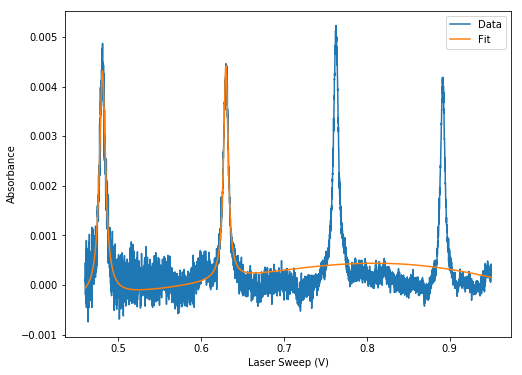

In [16]:
plt.figure(figsize=(8,6))
plt.xlabel("Laser Sweep (V)")
plt.ylabel("Absorbance")
plt.plot(raw_red['x'], Absorb, label = "Data")
plt.plot(raw_red['x'], Voigt_sum(raw_red['x'], *tuple(poptiV)), label = "Fit")
plt.legend(loc = "upper right")
#plt.xlim(2.11,2.16)
plt.show()

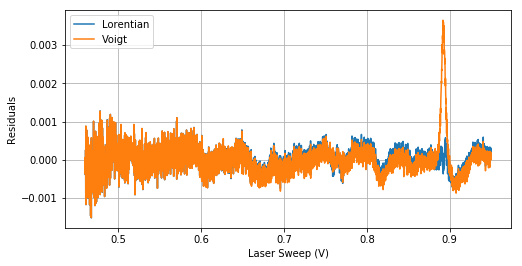

In [52]:
plt.figure(figsize=(8,4))
#plt.xlim(2.11,2.16)
plt.xlabel("Laser Sweep (V)")
plt.ylabel("Residuals")
plt.plot(raw_red['x'], resid, label="Lorentian")
plt.plot(raw_red['x'], residV, label="Voigt")
plt.grid()
plt.legend()
plt.show()

In [ ]:
xmin = 1.92
xmax = 1.96

f = plt.figure(figsize=(8,8));

plt.subplot(2,1,1)


plt.xlabel("Laser Sweep (V)")
plt.ylabel("Absorbance")
plt.plot(raw_red['x'], Absorb, label = "Data")
plt.plot(raw_red['x'], Voigt_sum(raw_red['x'], *tuple(poptiV)), label = "Fit")
plt.legend(loc = "upper right")
plt.grid()
plt.xlim(xmin,xmax)

plt.subplot(2,1,2)
plt.xlim(xmin,xmax)

plt.xlabel("Laser Sweep (V)")
plt.ylabel("Residuals")
plt.plot(raw_red['x'], resid, label="(data-fit) Lorentian")
plt.plot(raw_red['x'], residV, label="(data-fit) Voigt")
plt.grid()
plt.legend()
plt.show()

In [ ]:
np.std(resid)

In [ ]:
popti

In [92]:
df = pd.DataFrame({'x':raw_red['x'], 'y':Absorb})
df.to_csv('D_' + filename + '.dat', index = False, sep = '\t')
df = pd.DataFrame({'x':raw_red['x'], 'y':resid})
df.to_csv('R_' + filename + '.dat', index = False, sep = '\t')

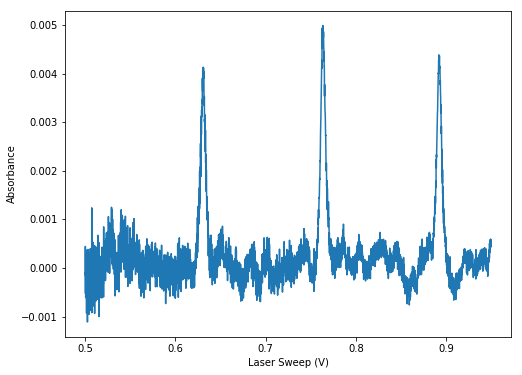

In [93]:
xmin = 0.5
xmax = 0.95
Absorb_red = Absorb[(raw_red['x'] > xmin) & (raw_red['x'] < xmax)]
x_red = raw_red[(raw_red['x'] > xmin) & (raw_red['x'] < xmax)]['x']

plt.figure(figsize=(8,6))
plt.xlabel("Laser Sweep (V)")
plt.ylabel("Absorbance")
plt.plot(x_red, Absorb_red, label = "Data")
plt.show()

In [94]:
np.std(Absorb_red)

0.0007892439794502775

In [17]:
beta=(np.max(raw_red['x'])-np.min(raw_red['x']))/Absorb.shape[0]

In [18]:
k,DFT = mv.DFT(Absorb.shape[0], beta, raw_red['x'], Absorb)

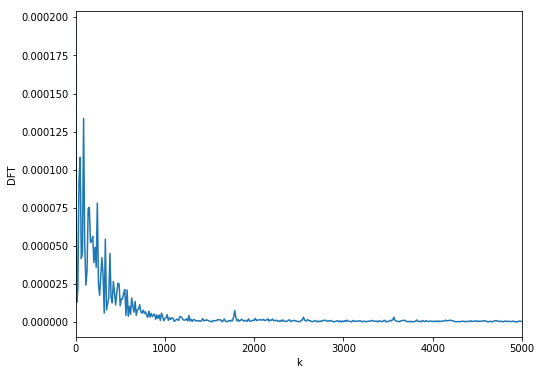

In [19]:
fig=plt.figure(figsize=(8,6))

#plt.figure(figsize=(8,6))
plt.xlim(0.0,5000)
#plt.ylim(0,0.001)
plt.xlabel("k")
plt.ylabel("DFT")
plt.plot(k, DFT, label = "DFT")
plt.show()

In [152]:
fig.savefig('FFT_Z5_w_Reflector_z=380.pdf', format='pdf', dpi=300,bbox_inches='tight')